In [16]:
#STEP 0:IMPORT NEEDED LIBRARY
import warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [17]:
#STEP 1:LOAD DATASET

file_path = '/kaggle/input/healthcare/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file_path)
print("Data shape (rows, cols):", df.shape)
display(df.head())
print("\nMissing values by column:")
display(df.isnull().sum())


Data shape (rows, cols): (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Missing values by column:


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

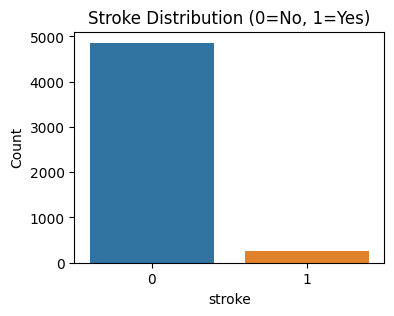

Class proportions:


stroke
No Stroke    0.951272
Stroke       0.048728
Name: proportion, dtype: float64

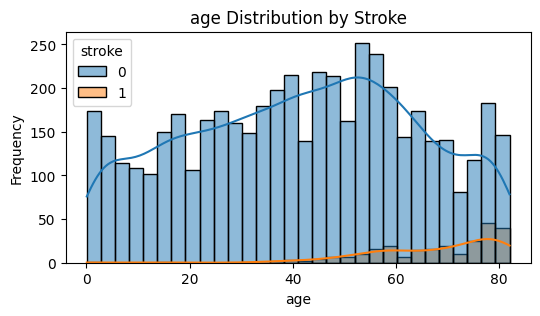

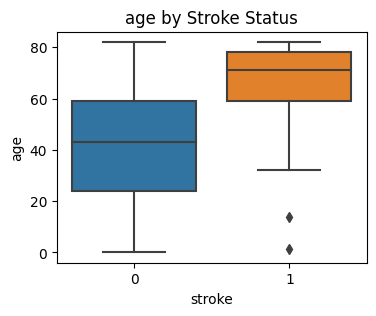

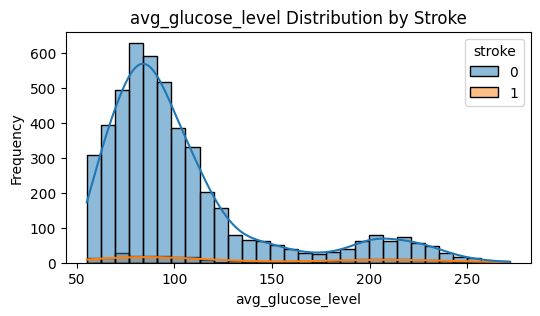

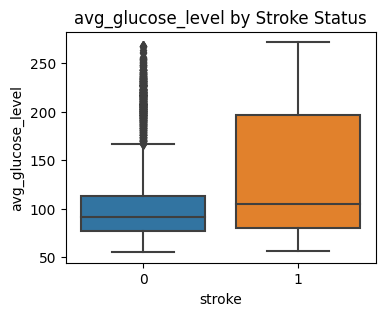

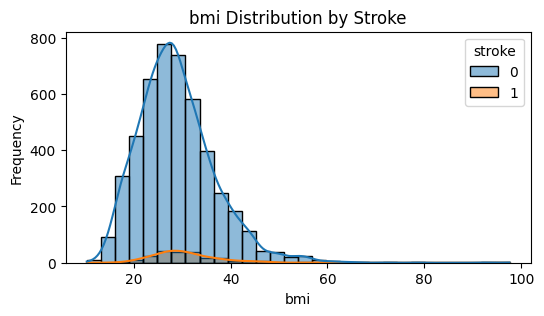

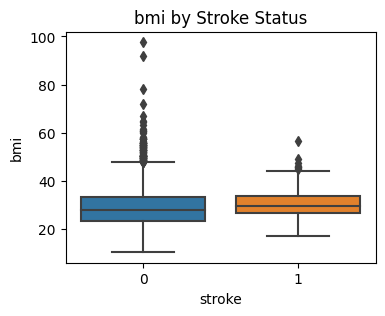

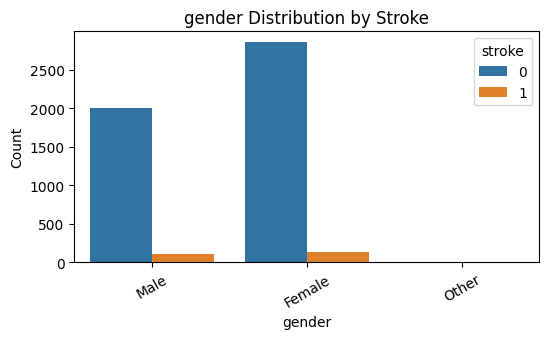

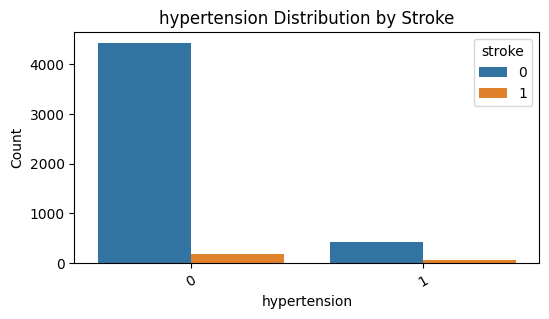

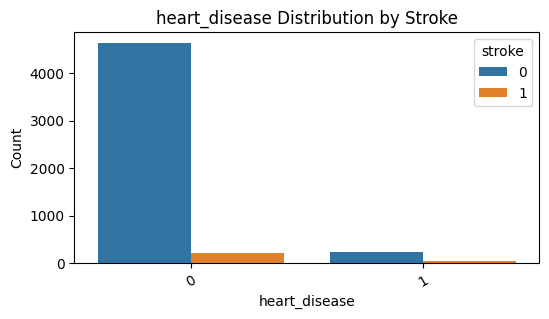

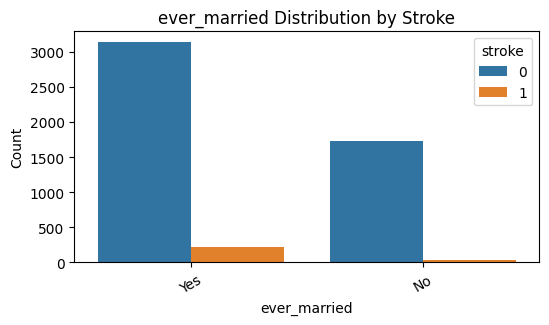

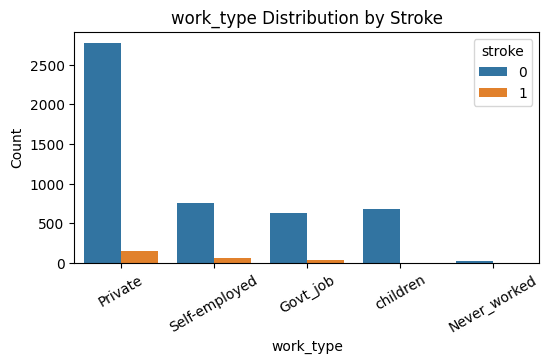

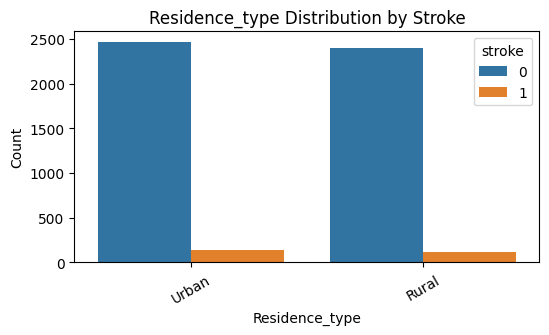

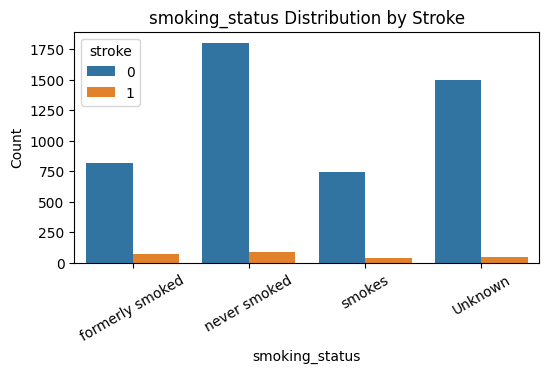

In [18]:
#STEP 2:EDA
plt.figure(figsize=(4,3))
sns.countplot(x='stroke', data=df)
plt.title('Stroke Distribution (0=No, 1=Yes)')
plt.xlabel('stroke')
plt.ylabel('Count')
plt.show()
print("Class proportions:")
display(df['stroke'].value_counts(normalize=True).rename(index={0:"No Stroke",1:"Stroke"}))

for col in ['age', 'avg_glucose_level', 'bmi']:
    plt.figure(figsize=(6,3))
    sns.histplot(data=df, x=col, hue='stroke', kde=True, bins=30)
    plt.title(f'{col} Distribution by Stroke')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(4,3))
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} by Stroke Status')
    plt.xlabel('stroke')
    plt.ylabel(col)
    plt.show()

for col in ['gender', 'hypertension', 'heart_disease', 'ever_married', 
            'work_type', 'Residence_type', 'smoking_status']:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='stroke', data=df)
    plt.title(f'{col} Distribution by Stroke')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=30)
    plt.show()

In [19]:
#STEP 3:Missing values&Outliers PROCESSING

print(f"\nBefore imputation, BMI missing count: {df['bmi'].isnull().sum()}")
bmi_median = df['bmi'].median()
df['bmi'].fillna(bmi_median, inplace=True)
print(f"Filled missing BMI with median = {bmi_median:.2f}")
print(f"After imputation, BMI missing count: {df['bmi'].isnull().sum()}")


for col in ['age', 'avg_glucose_level', 'bmi']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df.loc[df[col] < lower, col] = lower
    df.loc[df[col] > upper, col] = upper
    print(f"{col} capped to [ {lower:.2f}, {upper:.2f} ]")



Before imputation, BMI missing count: 201
Filled missing BMI with median = 28.10
After imputation, BMI missing count: 0
age capped to [ -29.00, 115.00 ]
avg_glucose_level capped to [ 21.98, 169.36 ]
bmi capped to [ 10.30, 46.30 ]


In [20]:
#STEP 4:Coding&Standardization
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)


df_encoded = pd.get_dummies(df, 
                            columns=['gender','ever_married','work_type',
                                     'Residence_type','smoking_status'],
                            drop_first=True)


X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"\nTraining size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print("Training stroke proportion:", y_train.mean())
print("Test stroke proportion:", y_test.mean())


scaler = StandardScaler()
cont_cols = ['age','avg_glucose_level','bmi']
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test[cont_cols]  = scaler.transform(X_test[cont_cols])


Training size: 4088, Test size: 1022
Training stroke proportion: 0.04867906066536203
Test stroke proportion: 0.04892367906066536


In [21]:
#STEP 5:SMOTE
print("\nBefore SMOTE, training class counts:")
print(y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE, training class counts:")
print(pd.Series(y_train_res).value_counts())


Before SMOTE, training class counts:
stroke
0    3889
1     199
Name: count, dtype: int64
After SMOTE, training class counts:
stroke
0    3889
1    3889
Name: count, dtype: int64


In [22]:
#STEP 6:FEATURE PROCESSING
if ('smoking_status_formerly smoked' in X_train_res.columns 
    and 'smoking_status_smokes' in X_train_res.columns):
    X_train_res['ever_smoked'] = ((X_train_res['smoking_status_formerly smoked']==1) |
                                  (X_train_res['smoking_status_smokes']==1)).astype(int)
    X_test['ever_smoked'] = ((X_test['smoking_status_formerly smoked']==1) |
                             (X_test['smoking_status_smokes']==1)).astype(int)
else:
    X_train_res['ever_smoked'] = 0
    X_test['ever_smoked'] = 0

#CREATE risk_factor_count
for df_ in [X_train_res, X_test]:
    df_['risk_factor_count'] = (df_['hypertension'].astype(int) +
                                df_['heart_disease'].astype(int) +
                                df_['ever_smoked'].astype(int))

#SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train_res, y_train_res)
mask = selector.get_support()
selected_feats = X_train_res.columns[mask]
print(f"\nSelected 10 features: {selected_feats.tolist()}")

X_train_final = X_train_res[selected_feats].copy()
X_test_final  = X_test[selected_feats].copy()

print(f"X_train_final shape: {X_train_final.shape}, X_test_final shape: {X_test_final.shape}")


Selected 10 features: ['age', 'avg_glucose_level', 'gender_Male', 'ever_married_Yes', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'ever_smoked', 'risk_factor_count']
X_train_final shape: (7778, 10), X_test_final shape: (1022, 10)



--- Baseline Model Performance ---
Logistic Regression -> Accuracy=0.7691, Precision=0.1504, Recall=0.8000, F1=0.2532, AUC=0.8342
Random Forest -> Accuracy=0.8640, Precision=0.1440, Recall=0.3600, F1=0.2057, AUC=0.7291


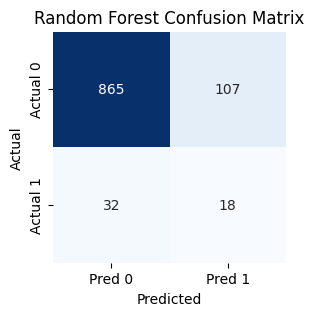

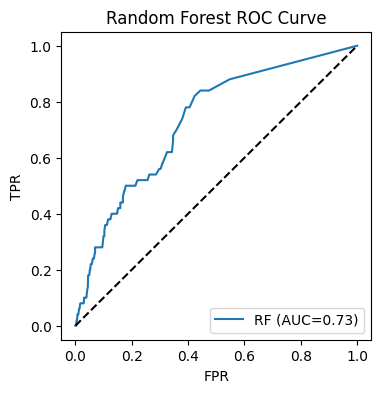

In [23]:
#STEP 7:ML Training&Evaluation


#confusion_matrix
def print_metrics(y_true, y_pred, y_prob, name):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    print(f"{name} -> Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

print("\n--- Baseline Model Performance ---")
print_metrics(y_test, y_pred_log, y_prob_log, "Logistic Regression")
print_metrics(y_test, y_pred_rf, y_prob_rf, "Random Forest")


cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(3,3))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['Actual 0','Actual 1'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(4,4))
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_score(y_test, y_prob_rf):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6573 - loss: 0.6118 - val_accuracy: 0.8445 - val_loss: 0.4796
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7817 - loss: 0.4698 - val_accuracy: 0.8625 - val_loss: 0.4356
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7919 - loss: 0.4506 - val_accuracy: 0.8483 - val_loss: 0.4417
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7805 - loss: 0.4436 - val_accuracy: 0.8355 - val_loss: 0.4606
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8007 - loss: 0.4321 - val_accuracy: 0.8483 - val_loss: 0.4388
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7846 - loss: 0.4295 - val_accuracy: 0.8239 - val_loss: 0.4664
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7984 - loss: 0.4243 - val_accuracy: 0.8393 - val_loss: 0.4311
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7893 - loss: 0.4293 - val_accuracy: 0.

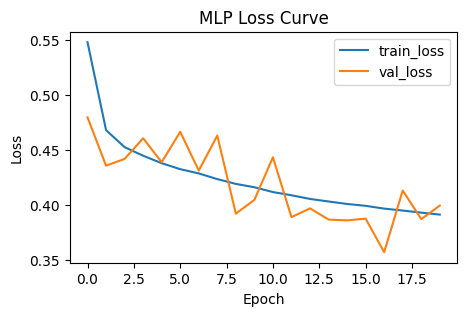

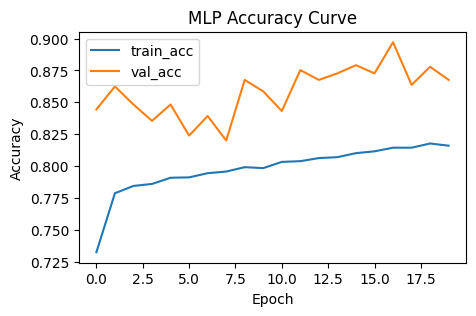

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
=== Deep Learning MLP Performance ===
Accuracy  = 0.7847
Precision = 0.1304
Recall    = 0.6000
F1        = 0.2143
AUC       = 0.7893


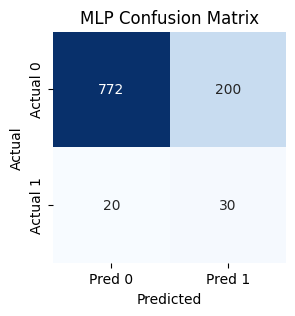

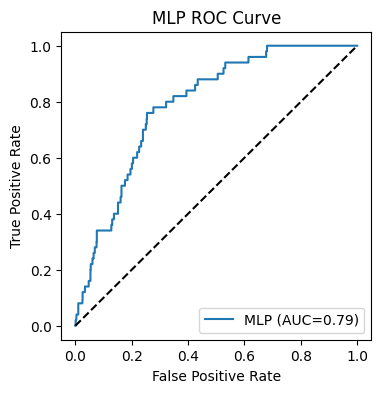

In [24]:
#STEP 8:DL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1 :MLP 
def build_simple_mlp(input_dim):
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(input_dim,)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 2 :TRAININGG
input_dim = X_train_final.shape[1]
model = build_simple_mlp(input_dim)
history = model.fit(
    X_train_final, y_train_res,
    epochs=20,            
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# 3 : Loss&Accuracy CURVE
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('MLP Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('MLP Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 4 :MATRIC
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import seaborn as sns

y_prob = model.predict(X_test_final).ravel()
y_pred = (y_prob >= 0.5).astype(int)


acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print("=== Deep Learning MLP Performance ===")
print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {prec:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")
print(f"AUC       = {auc:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['Actual 0','Actual 1'])
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 5 :ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"MLP (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')
plt.legend(loc='lower right')
plt.show()
